# `nb05`: State-space models

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Time discretization
dt = 0.01          # fine time step for SDE simulation
Delta = 0.25       # observation interval (10 * dt)
T = 20.0           # total time
n_steps = int(T / dt)
obs_interval = int(Delta / dt)

# Continuous-time OU process parameters
mu = np.array([0.0, 0.0])
kappa_diag = np.array([0.25, 0.25])
sigma_diag = np.array([0.1, 0.1])
z0 = np.array([2.0, 1.0])

# Observation noise
R = np.eye(2) * 0.05**2


In [7]:

# Continuous-time SDE simulation (ground truth)
def simulate_sde(z0, n_steps, dt):
    """Simulate OU process using Euler-Maruyama"""
    trajectory = np.zeros((n_steps + 1, 2))
    trajectory[0] = z0
    
    for i in range(n_steps):
        z = trajectory[i]
        dB = np.random.normal(size=2) * np.sqrt(dt)
        dz = -kappa_diag * (z - mu) * dt + sigma_diag * dB
        trajectory[i + 1] = z + dz
    
    return trajectory

# Generate ground truth trajectory
z_true = simulate_sde(z0, n_steps, dt)

# Extract observations at coarse time steps
obs_times = np.arange(0, n_steps + 1, obs_interval)
z_obs_true = z_true[obs_times]
x_obs = z_obs_true + np.random.normal(size=z_obs_true.shape) @ np.sqrt(R)

In [8]:

# Discrete-time LGSSM (for inference)

# Exact discretization of OU process at observation interval Delta
A_diag = np.exp(-kappa_diag * Delta)
b = (1 - A_diag) * mu
Q_diag = (sigma_diag**2 / (2 * kappa_diag)) * (1 - np.exp(-2 * kappa_diag * Delta))

A = np.diag(A_diag)
Q = np.diag(Q_diag)
H = np.eye(2)

print(f"A = {A}")
print(f"Q = {Q}")
print(f"H = {H}")

A = [[0.93941306 0.        ]
 [0.         0.93941306]]
Q = [[0.00235006 0.        ]
 [0.         0.00235006]]
H = [[1. 0.]
 [0. 1.]]


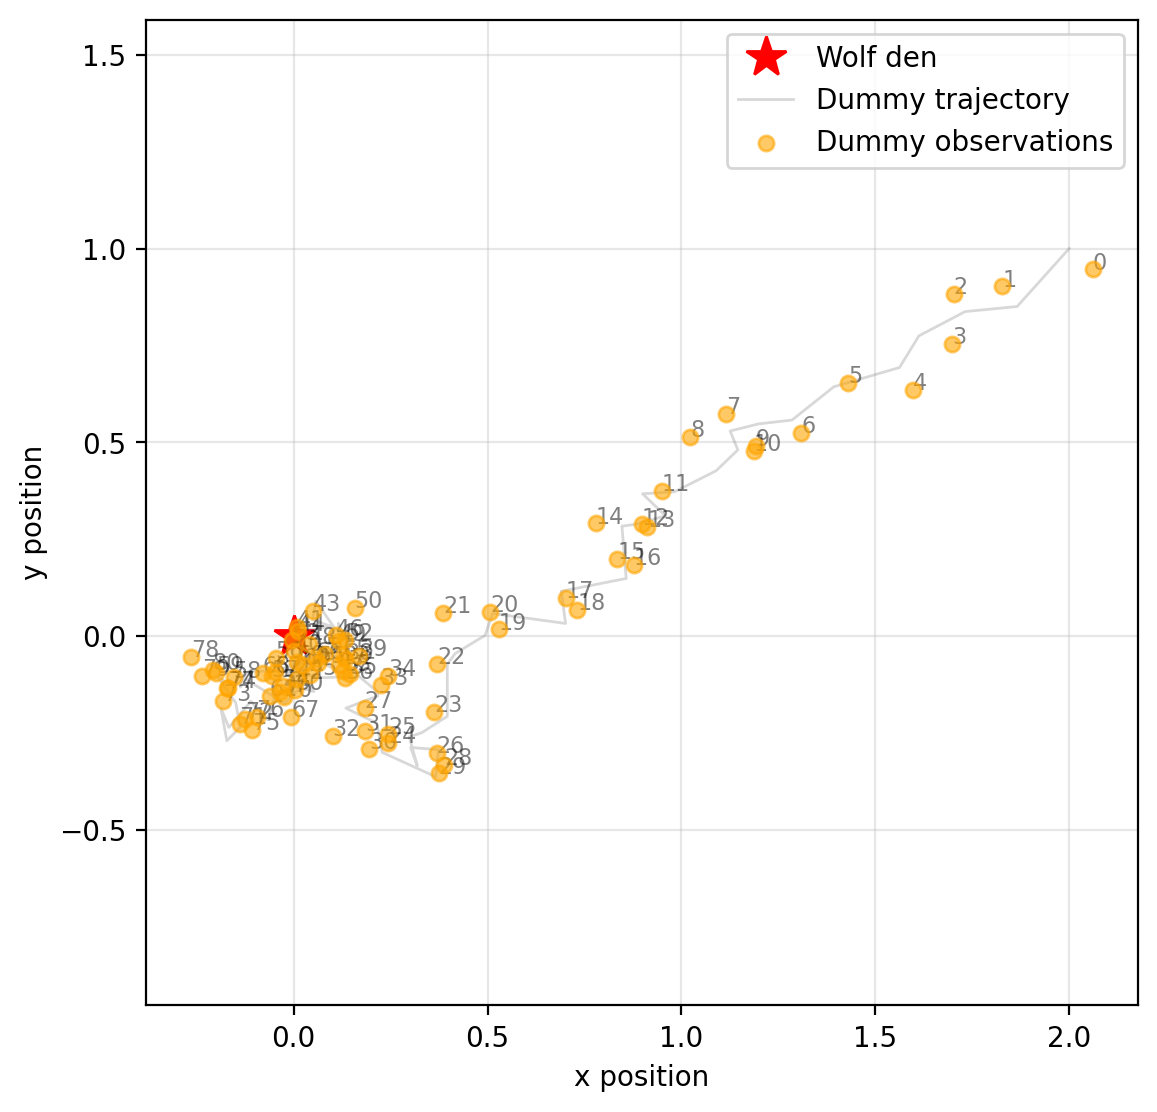

In [9]:

# Generate a dummy trajectory
dummy_trajectory = np.zeros_like(z_obs_true)
dummy_trajectory[0] = z_obs_true[0]
for i in range(1, len(obs_times)):
    dummy_trajectory[i] = A @ dummy_trajectory[i - 1] + b
    dummy_trajectory[i] += np.random.normal(size=2) @ np.sqrt(Q)
dummy_observations = dummy_trajectory + np.random.normal(size=dummy_trajectory.shape) @ np.sqrt(R)

# Show dummy trajectory
fig = plt.figure(figsize=(6.4, 6.4), dpi=200)
ax = plt.axes()

ax.plot(mu[0], mu[1], 'r*', markersize=15, label='Wolf den')
ax.plot(dummy_trajectory[:, 0], dummy_trajectory[:, 1], 'gray', alpha=0.3, linewidth=1, label='Dummy trajectory')
ax.scatter(dummy_observations[:, 0], dummy_observations[:, 1], c='orange', s=30, alpha=0.6, label='Dummy observations', zorder=5)
for i, (x, y) in enumerate(dummy_observations):
    ax.text(x, y, str(i), fontsize=8, alpha=0.5)

ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')   
ax.set_xlabel('x position')
ax.set_ylabel('y position') 

plt.savefig('wolf-dummy-trajectory.png')
plt.show()

In [10]:
# Kalman Filter
def kalman_filter(x_obs, z0_mean, z0_cov):
    """Run Kalman filter on observations"""
    n_obs = len(x_obs)
    
    # Storage
    m_pred = np.zeros((n_obs, 2))
    P_pred = np.zeros((n_obs, 2, 2))
    m_filt = np.zeros((n_obs, 2))
    P_filt = np.zeros((n_obs, 2, 2))
    
    # Initial condition
    m = z0_mean
    P = z0_cov
    
    for t in range(n_obs):
        # Prediction step
        m_pred[t] = A @ m + b
        P_pred[t] = A @ P @ A.T + Q
        
        # Update step
        S = H @ P_pred[t] @ H.T + R
        K = P_pred[t] @ H.T @ np.linalg.inv(S)
        
        m_filt[t] = m_pred[t] + K @ (x_obs[t] - H @ m_pred[t])
        P_filt[t] = (np.eye(2) - K @ H) @ P_pred[t]
        
        # Prepare for next iteration
        m = m_filt[t]
        P = P_filt[t]
    
    return m_filt, P_filt, m_pred, P_pred

# Run Kalman filter
z0_mean = mu  # prior mean at home location
z0_cov = np.eye(2) * 1.0  # uncertain initial position
m_filt, P_filt, m_pred, P_pred = kalman_filter(x_obs, z0_mean, z0_cov)

In [11]:

# Kalman Smoother (RTS)
def kalman_smoother(m_filt, P_filt, m_pred, P_pred):
    """Run RTS smoother"""
    n_obs = len(m_filt)
    
    m_smooth = np.zeros_like(m_filt)
    P_smooth = np.zeros_like(P_filt)
    
    # Initialize with filtered estimates
    m_smooth[-1] = m_filt[-1]
    P_smooth[-1] = P_filt[-1]
    
    # Backward pass
    for t in range(n_obs - 2, -1, -1):
        C = P_filt[t] @ A.T @ np.linalg.inv(P_pred[t + 1])
        m_smooth[t] = m_filt[t] + C @ (m_smooth[t + 1] - m_pred[t + 1])
        P_smooth[t] = P_filt[t] + C @ (P_smooth[t + 1] - P_pred[t + 1]) @ C.T
    
    return m_smooth, P_smooth

# Run Kalman smoother
m_smooth, P_smooth = kalman_smoother(m_filt, P_filt, m_pred, P_pred)

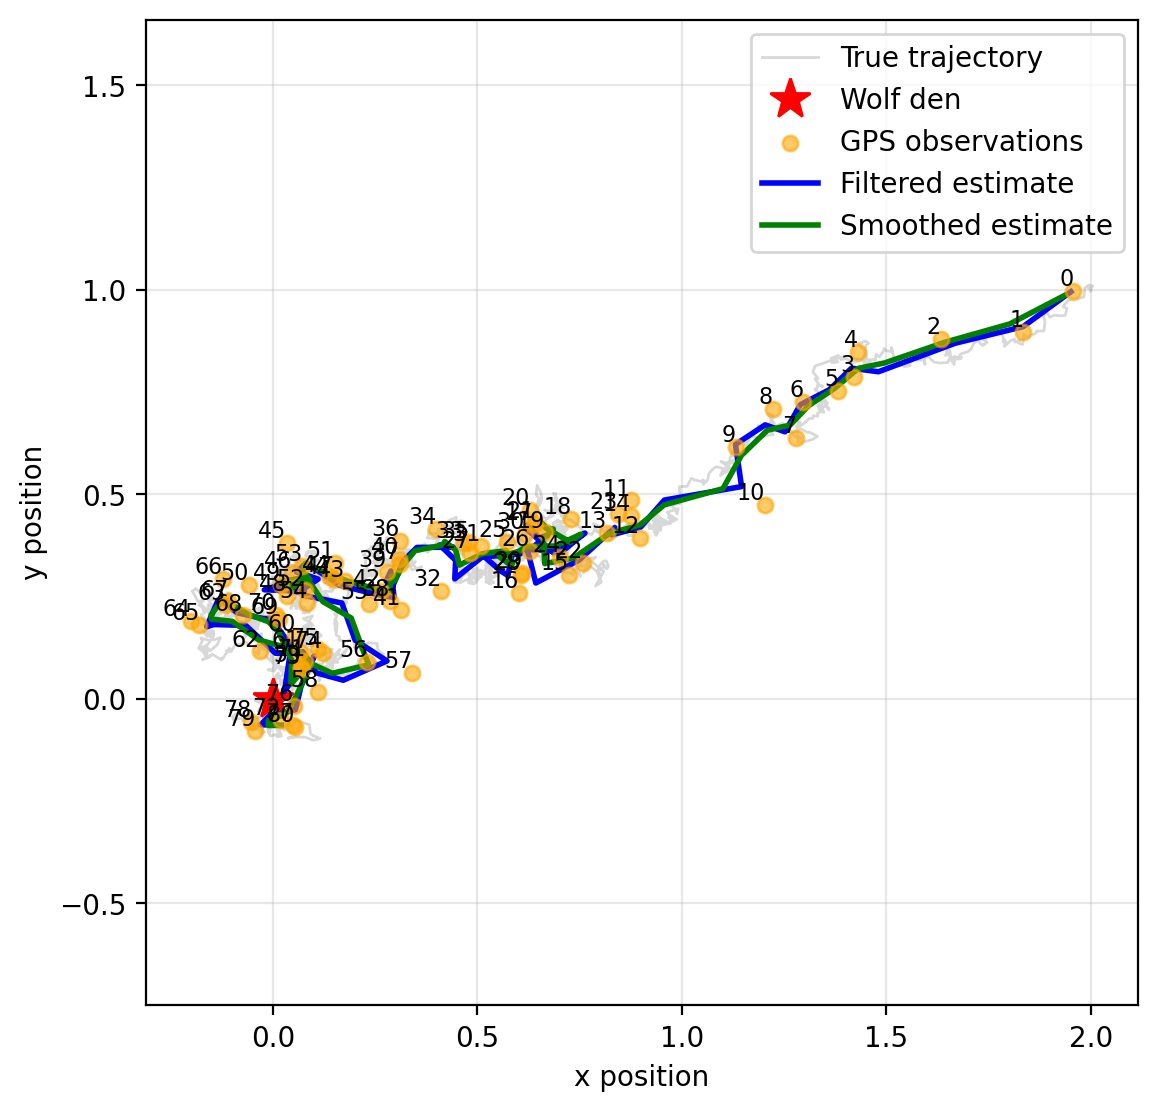

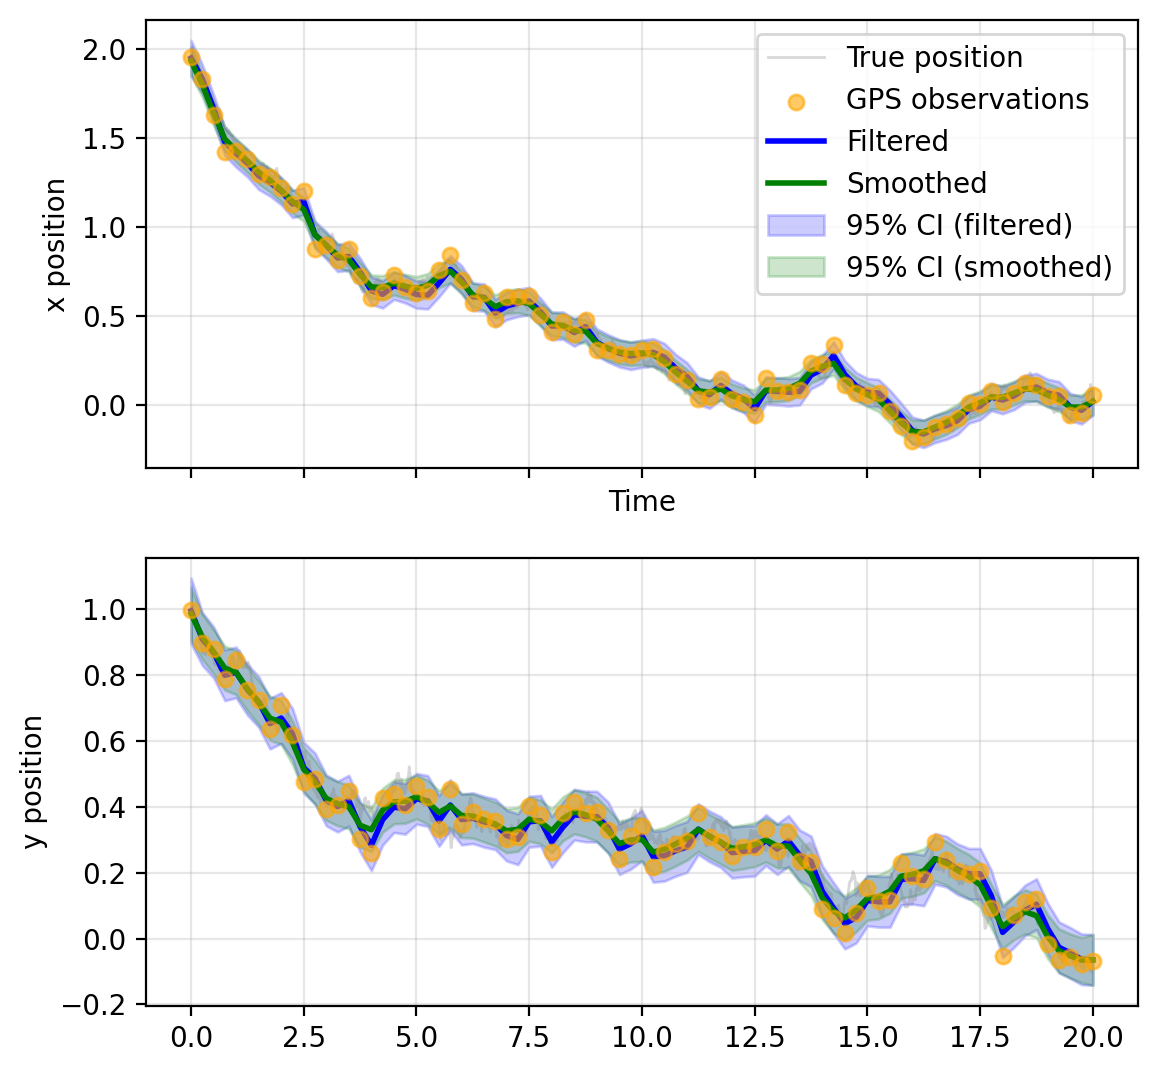

In [13]:

# Visualization

# Plot 1: Trajectories
fig = plt.figure(figsize=(6.4, 6.4), dpi=200)
ax = plt.axes()

t_fine = np.arange(n_steps + 1) * dt
t_obs = obs_times * dt

ax.plot(z_true[:, 0], z_true[:, 1], 'gray', alpha=0.3, linewidth=1, label='True trajectory')
ax.plot(mu[0], mu[1], 'r*', markersize=15, label='Wolf den')
ax.scatter(x_obs[:, 0], x_obs[:, 1], c='orange', s=30, alpha=0.6, label='GPS observations', zorder=5)
for i, (x, y) in enumerate(x_obs):
    ax.text(x, y, str(i), fontsize=8, ha='right', va='bottom', color='black', zorder=6)
ax.plot(m_filt[:, 0], m_filt[:, 1], 'b-', linewidth=2, label='Filtered estimate', zorder=3)
ax.plot(m_smooth[:, 0], m_smooth[:, 1], 'g-', linewidth=2, label='Smoothed estimate', zorder=4)

ax.set_xlabel('x position')
ax.set_ylabel('y position')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')

#plt.savefig('wolf-true-trajectory.png')
plt.show()

# Plot 2: XY-coordinate over time
fig, ax = plt.subplots(2, 1, figsize=(6.4, 6.4), dpi=200, sharex=True)

for i in range(2):
    ax[i].plot(t_fine, z_true[:, i], 'gray', alpha=0.3, linewidth=1, label='True position')
    ax[i].scatter(t_obs, x_obs[:, i], c='orange', s=30, alpha=0.6, label='GPS observations', zorder=5)
    ax[i].plot(t_obs, m_filt[:, i], 'b-', linewidth=2, label='Filtered', zorder=3)
    ax[i].plot(t_obs, m_smooth[:, i], 'g-', linewidth=2, label='Smoothed', zorder=4)

    std_filt = np.sqrt([P_filt[i, 0, 0] for i in range(len(P_filt))])
    std_smooth = np.sqrt([P_smooth[i, 0, 0] for i in range(len(P_smooth))])
    ax[i].fill_between(t_obs, m_filt[:, i] - 2*std_filt, m_filt[:, i] + 2*std_filt, 
                       alpha=0.2, color='blue', label='95% CI (filtered)')
    ax[i].fill_between(t_obs, m_smooth[:, i] - 2*std_smooth, m_smooth[:, i] + 2*std_smooth, 
                       alpha=0.2, color='green', label='95% CI (smoothed)')
    
    ax[i].set_ylabel('x position' if i == 0 else 'y position')

ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].grid(True, alpha=0.3)
ax[1].grid(True, alpha=0.3) 

#plt.savefig('wolf-kalman-filter-time-series.png')
plt.show()
